# Chapter 7. Aggregations
- Aggregating Basics:
  - Aggregating involves collecting data together and is key to big data analytics.
  - Specify a key/grouping and an aggregation function to transform columns into a single result for each group.
  - Aggregation types include summation, product, counting, and more.
  - Aggregations can summarize numerical data by grouping, and can also aggregate values into arrays, lists, or maps.
- Grouping Types in Spark:
  - Simple Grouping: Summarize an entire DataFrame using an aggregation in a select statement.
  - Group By: Specify keys and aggregation functions to transform value columns.
  - Window: Specify keys and aggregation functions where the rows input to the function are related to the current row.
  - Grouping Set: Aggregate at multiple levels, available as a primitive in SQL and via rollups and cubes in DataFrames.
  - Rollup: Specify keys and aggregation functions, summarized hierarchically.
  - Cube: Specify keys and aggregation functions, summarized across all combinations of columns.

Each grouping returns a RelationalGroupedDataset for specifying aggregations.

> Important Note: Consider the accuracy required for your answers. Exact answers can be expensive on large data. Approximations are often sufficient and more cost-effective for reasonable accuracy. Some approximation functions in Spark can improve speed and execution, especially for interactive and ad hoc analysis.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.sql.shuffle.partitions", "5")\
    .appName("Aggregations")\
    .getOrCreate()

24/08/08 15:48:59 WARN Utils: Your hostname, Khanhs-MAC.local resolves to a loopback address: 127.0.0.1; using 192.168.254.32 instead (on interface en0)
24/08/08 15:48:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/08 15:49:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.format("csv")\
  .option("header", "true")\
    .option("inferSchema", "true")\
      .load("../data/retail-data/all/*.csv")\
        .coalesce(5)

df.cache()
df.createOrReplaceTempView("dfTable")
df.show(5)


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [3]:
df.count() == 541909

True

- Count as an Action:
  - count is an action, not a transformation, meaning it returns results immediately.
  - Useful for getting the total size of a dataset.
  - Can be used to cache an entire DataFrame in memory.
- Eager Evaluation:
  - Unlike typical lazy transformations, count is eagerly evaluated when used as a method.
  - This method stands out because it behaves differently from most Spark operations.

## Aggregation Functions
- Availability:
  - Aggregations are available as functions.
  - Can be applied to DataFrames or via .stat.
- Reference:
  - Most aggregation functions are found in the org.apache.spark.sql.functions package.
- Note:
  - There are gaps between available SQL functions and those importable in Scala and Python.
  - This gap changes with each release, making a definitive list impractical.

### count
- The count function performs as a transformation instead of an action in this context.
- You can either specify a specific column to count or count all columns using count(*) or count(1).

In [4]:
# in Python
from pyspark.sql.functions import count
df.select(count("StockCode")).show() # 541909

+----------------+
|count(StockCode)|
+----------------+
|          541909|
+----------------+



> - count(*) will include null values.
>- Counting an individual column will not count the null values.

### countDistinct
- The total number of items may not always be relevant; instead, the number of unique groups may be of interest.
- To find the number of unique groups, use the countDistinct function.
- countDistinct is particularly useful for individual columns.
- It helps in identifying the diversity or uniqueness within the data.
- Provides insight into the number of unique values or groups in a column.

In [5]:
from pyspark.sql.functions import countDistinct

df.select(countDistinct("StockCode")).show()

+-------------------------+
|count(DISTINCT StockCode)|
+-------------------------+
|                     4070|
+-------------------------+



### approx_count_distinct
- Useful for large datasets where exact distinct counts are not necessary.
- *approx_count_distinct* provides an approximation to a specified degree of accuracy.

In [6]:
from pyspark.sql.functions import approx_count_distinct

df.select(approx_count_distinct("StockCode", 0.1)).show()

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|                            3364|
+--------------------------------+



- Takes a parameter for maximum estimation error allowed (e.g., 0.1).
- Completes more quickly than countDistinct and provides significant performance gains for larger datasets.

### first and last
- You can get first and last values from a DataFrame using fist and last functions.

In [7]:
from pyspark.sql.functions import first, last

df.select(first("StockCode"), last("StockCode")).show()

+----------------+---------------+
|first(StockCode)|last(StockCode)|
+----------------+---------------+
|          85123A|          22138|
+----------------+---------------+



### min and max

In [8]:
from pyspark.sql.functions import min, max

df.select(min("Quantity"), max("Quantity")).show()

+-------------+-------------+
|min(Quantity)|max(Quantity)|
+-------------+-------------+
|       -80995|        80995|
+-------------+-------------+



### sum

In [9]:
from pyspark.sql.functions import sum

df.select(sum("Quantity")).show()

+-------------+
|sum(Quantity)|
+-------------+
|      5176450|
+-------------+



### sum_distinct
- You can also sum a distinct set of values by using the sumDistinct function.

In [10]:
from pyspark.sql.functions import sum_distinct

df.select(sum_distinct("Quantity")).show()

+----------------------+
|sum(DISTINCT Quantity)|
+----------------------+
|                 29310|
+----------------------+



### avg
- Use *avg* or *mean* functions to calculate the average value.

In [11]:
from pyspark.sql.functions import sum, count, avg, expr

df.select(
  count("Quantity").alias("total_transactions"),
  sum("Quantity").alias("total_purchases"),
  avg("Quantity").alias("avg_purchases"),
  expr("mean(Quantity)").alias("mean_purchases"))\
    .selectExpr(
      "total_purchases/total_transactions",
      "avg_purchases",
      "mean_purchases").show()

+--------------------------------------+----------------+----------------+
|(total_purchases / total_transactions)|   avg_purchases|  mean_purchases|
+--------------------------------------+----------------+----------------+
|                      9.55224954743324|9.55224954743324|9.55224954743324|
+--------------------------------------+----------------+----------------+



### Variance and Standard Deviation
- Mean Calculation:
  - Brings up questions about variance and standard deviation.
  - Measures the spread of data around the mean.
- Variance:
  - Average of squared differences from the mean.
  - Calculated using specific functions in Spark.
- Standard Deviation:
  - Square root of the variance.
  - Indicates the spread of data around the mean.
- Spark Functions:
  - Provides functions for both sample and population standard deviation.
  - variance or stddev functions calculate sample standard deviation/variance by default.

In [12]:
from pyspark.sql.functions import var_pop, stddev_pop, var_samp, stddev_samp

df.select(var_pop("Quantity"), var_samp("Quantity"),
          stddev_pop("Quantity"), stddev_samp("Quantity")).show()


+------------------+------------------+--------------------+---------------------+
| var_pop(Quantity)|var_samp(Quantity)|stddev_pop(Quantity)|stddev_samp(Quantity)|
+------------------+------------------+--------------------+---------------------+
|47559.303646609056|47559.391409298754|  218.08095663447796|   218.08115785023418|
+------------------+------------------+--------------------+---------------------+



### skewness and kurtosis
- Skewness and Kurtosis:
  - Skewness: Measures the asymmetry of values around the mean.
  - Kurtosis: Measures the tails of the data distribution.
- Relevance:
  - Important when modeling data as a probability distribution of a random variable.
- Additional Information:
  - Detailed mathematical definitions are readily available online.
- Calculation:
  - Spark provides functions to calculate skewness and kurtosis.

In [13]:
# in Python
from pyspark.sql.functions import skewness, kurtosis
df.select(skewness("Quantity"), kurtosis("Quantity")).show()

+-------------------+------------------+
| skewness(Quantity)|kurtosis(Quantity)|
+-------------------+------------------+
|-0.2640755761052562|119768.05495536952|
+-------------------+------------------+



### Covariance and Correlation
- Covariance (cov):
	- Measures how two variables change together.
	- Can be calculated as sample covariance or population covariance.
- Correlation (corr):
	- Measures Pearson correlation coefficient.
	- Scaled between -1 and +1.
	- No distinction between sample and population correlation.
- *cov* and *corr* functions in Spark:
	- *cov* can specify sample or population covariance.
	- *corr* calculates Pearson correlation without sample/population distinction.

In [14]:
from pyspark.sql.functions import corr, covar_pop, covar_samp

df.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"),
  covar_pop("InvoiceNo", "Quantity")).show()

+-------------------------+-------------------------------+------------------------------+
|corr(InvoiceNo, Quantity)|covar_samp(InvoiceNo, Quantity)|covar_pop(InvoiceNo, Quantity)|
+-------------------------+-------------------------------+------------------------------+
|     4.912186085635685E-4|             1052.7280543902734|            1052.7260778741693|
+-------------------------+-------------------------------+------------------------------+



### Aggregating to Complex Types
- Aggregations can be performed on complex types, not just numerical values.
- Examples include:
	- Collecting a list of values present in a given column.
	- Collecting only the unique values by collecting to a set.
- Usage:
  - Useful for more programmatic access later in the pipeline.
  - Can pass the entire collection into a user-defined function (UDF).

In [15]:
from pyspark.sql.functions import collect_list, collect_set

df.agg(collect_set("Country"), collect_list("Country")).show()

+--------------------+---------------------+
|collect_set(Country)|collect_list(Country)|
+--------------------+---------------------+
|[Portugal, Italy,...| [United Kingdom, ...|
+--------------------+---------------------+



## Grouping
- DataFrame-Level Aggregations: Previously, only DataFrame-level aggregations were performed.
- Group-Level Aggregations:
  - More common task to perform calculations based on groups in the data.
  - Typically done on categorical data.
- Grouping Process:
  - Group data on one column.
  - Perform calculations on other columns within that group.
- Example:
  - Group by each unique invoice number.
  - Count the items on each invoice.
  - Returns another DataFrame, performed lazily.
- Steps for Grouping:
	1.	Specify the column(s) for grouping.
	2.	Specify the aggregation(s).
    - First step returns a RelationalGroupedDataset.
    - Second step returns a DataFrame.

In [16]:
df.groupBy("InvoiceNo", "CustomerId").count().show(4)

+---------+----------+-----+
|InvoiceNo|CustomerId|count|
+---------+----------+-----+
|   536366|     17850|    2|
|   536367|     13047|   12|
|   536369|     13047|    1|
|   536376|     15291|    2|
+---------+----------+-----+
only showing top 4 rows



### Grouping with Expression
- Counting as a Special Case:
  - Counting is unique because it exists as a method.
  - Preferred to use the *count* function.
- Using the *count* Function:
  - Instead of passing the function as an expression in a select statement, specify it within *agg*.
  - Allows passing arbitrary expressions needing aggregation.
- Additional Flexibility:
  - Possible to *alias* a column after transforming it.
  - Useful for later use in the data flow.

In [17]:
from pyspark.sql.functions import count

df.groupBy("InvoiceNo").agg(
  count("Quantity").alias("quan"),
  expr("count(Quantity)")).show()

+---------+----+---------------+
|InvoiceNo|quan|count(Quantity)|
+---------+----+---------------+
|   536370|  20|             20|
|   536380|   1|              1|
|   536384|  13|             13|
|   536387|   5|              5|
|   536397|   2|              2|
|   536405|   1|              1|
|   536407|   2|              2|
|   536463|   1|              1|
|   536500|  15|             15|
|   536522|  54|             54|
|   536523|  12|             12|
|   536536|   3|              3|
|   536538|  31|             31|
|   536542|  16|             16|
|   536555|   2|              2|
|   536561|  15|             15|
|   536573|   4|              4|
|   536579|   2|              2|
|   536580|   6|              6|
|   536582|  17|             17|
+---------+----+---------------+
only showing top 20 rows



### Grouping with Maps
- Map-Based Transformations:
  - Easier to specify transformations as a series of Maps.
  - The key is the column name.
  - The value is the aggregation function (as a string) to perform.
- Reuse Column Names:
  - Multiple column names can be reused if specified inline.

In [21]:
df.groupBy("InvoiceNo").agg(expr("avg(Quantity)"), expr("stddev_pop(Quantity)")).show()

+---------+------------------+--------------------+
|InvoiceNo|     avg(Quantity)|stddev_pop(Quantity)|
+---------+------------------+--------------------+
|   536370|             22.45|   8.935742834258381|
|   536380|              24.0|                 0.0|
|   536384|14.615384615384615|  15.750645708563392|
|   536387|             288.0|  117.57550765359255|
|   536397|              30.0|                18.0|
|   536405|             128.0|                 0.0|
|   536407|               6.0|                 0.0|
|   536463|              12.0|                 0.0|
|   536500|               6.8|   4.019950248448356|
|   536522|1.5925925925925926|  1.6046058535136642|
|   536523| 9.333333333333334|   7.487025815072067|
|   536536|31.666666666666668|  34.373762603991366|
|   536538| 4.709677419354839|  3.7173833008743054|
|   536542|              24.5|    8.73212459828649|
|   536555|               1.0|                 0.0|
|   536561| 9.333333333333334|  2.9814239699997196|
|   536573| 

## Window Functions
- Purpose:
  - Perform unique aggregations by computing some aggregation on a specific “window” of data.
  - Window specification determines which rows will be passed into the function.
- Difference from Group-By:
  - Group-By: Each row can go only into one grouping.
  - Window Function:
    - Calculates a return value for every input row based on a group of rows (called a frame).
    - Each row can fall into one or more frames.
- Use Case:
  - Example: Calculating a rolling average where each row represents one day.
  - Each row could end up in multiple frames (e.g., a 7-day rolling average would place each row in seven different frames).
- Types of Window Functions in Spark:
  - Ranking Functions: Assign ranks to rows within a partition.
  - Analytic Functions: Perform calculations across a set of table rows that are somehow related to the current row.
  - Aggregate Functions: Perform aggregations on a specified window of rows.
  
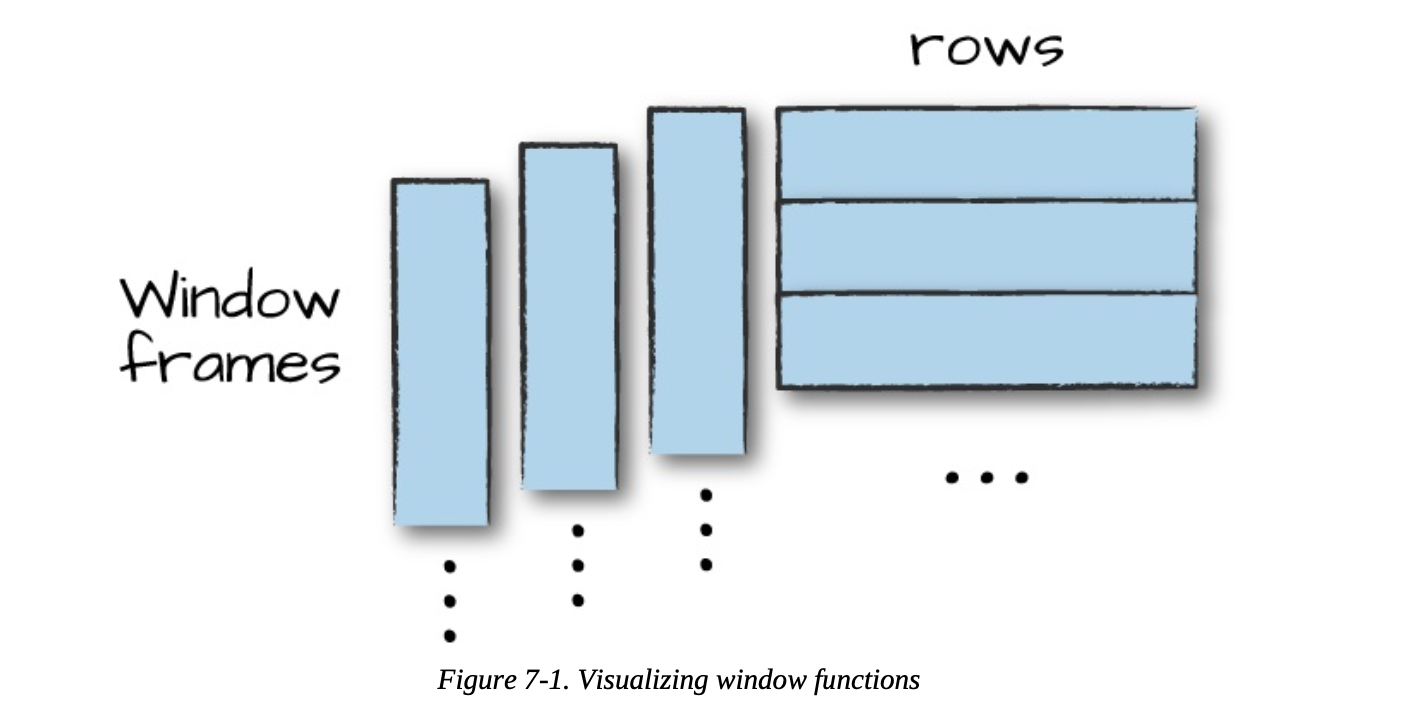

In [106]:
from pyspark.sql.functions import col, to_date, date_format

input_date_format = "M/d/yyyy H:mm"
output_date_format = "yyyy-MM-dd"
dfWithDate = df.withColumn("date",  date_format(to_timestamp(col("InvoiceDate"), input_date_format), output_date_format))
dfWithDate.createOrReplaceTempView("dfWithDate")

- Create Window Specification:
  - Partition By:
    - Defines how the data will be broken up into groups.
    - Different from the partitioning scheme used for data distribution.
  - Order By:
    - Defines the ordering within each partition.
  - Frame Specification:
    - Defines which rows are included in the frame relative to the current row.
    - Example: rowsBetween statement specifies the range of rows.

In [107]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc

windowSpec = Window\
    .partitionBy("CustomerId", "date")\
    .orderBy(desc("Quantity"))\
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

- Aggregation for Specific Customers:
  - Use aggregation functions to analyze data for each customer.
  - Example: Establish the maximum purchase quantity over time.
- Steps to Achieve This:
  - Use aggregation functions with column names or expressions.
  - Indicate the window specification to define the frames of data.


In [108]:
from pyspark.sql.functions import max
maxPurchaseQuantity = max(col("Quantity")).over(windowSpec)

- Aggregation Function:
  - Returns a column or expressions that can be used in a DataFrame select statement.
- Purchase Quantity Rank:
  - Use dense_rank to determine the date with the maximum purchase quantity for each customer.
  - dense_rank avoids gaps in the ranking sequence, unlike rank.

In [109]:
from pyspark.sql.functions import dense_rank, rank
purchaseDenseRank = dense_rank().over(windowSpec)
purchaseRank = rank().over(windowSpec)

- This also returns a column that we can use in select statements.

In [110]:
from pyspark.sql.functions import col

dfWithDate.where("CustomerId IS NOT NULL").orderBy("CustomerId")\
  .select(
    col("CustomerId"),
    col("date"),
    col("Quantity"),
    purchaseRank.alias("quantityRank"),
    purchaseDenseRank.alias("quantityDenseRank"),
    maxPurchaseQuantity.alias("maxPurchaseQuantity")).show()

+----------+----------+--------+------------+-----------------+-------------------+
|CustomerId|      date|Quantity|quantityRank|quantityDenseRank|maxPurchaseQuantity|
+----------+----------+--------+------------+-----------------+-------------------+
|     12346|2011-01-18|   74215|           1|                1|              74215|
|     12346|2011-01-18|  -74215|           2|                2|              74215|
|     12347|2010-12-07|      36|           1|                1|                 36|
|     12347|2010-12-07|      30|           2|                2|                 36|
|     12347|2010-12-07|      24|           3|                3|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|             

## Grouping Sets
- Simple group-by expressions allow for aggregating on a set of columns.
- Sometimes a more complete aggregation across multiple groups is needed.
- Grouping sets are a low-level tool for combining sets of aggregations.
- They enable creating arbitrary aggregations in group-by statements.
- Example scenario: calculating total quantity of all stock codes and customers.
- SQL expression used to achieve this aggregation.

In [111]:
dfNoNull = dfWithDate.drop()
dfNoNull.createOrReplaceTempView("dfNoNull")

> Grouping sets depend on null values for aggregation levels. If you do not filter-out null values, you will get incorrect results. This applies to cubes, rollups, and grouping sets.

- Conventional group-by statements can’t aggregate totals regardless of customer or stock code.
- Grouping sets allow for this by specifying the desired aggregation level.
- This method is effectively the union of several different groupings together.
- It enables including the total number of items regardless of specific groupings.
- To perform the same in DataFrame, you use the *rollup* and *cube* operators.

### Rollups
- Rollups Overview
  - Rollups perform multidimensional aggregations for a variety of group-by style calculations.
  - They consider explicit groupings and combinations in the dataset.
- Creating a Rollup
  - Rollup over time (Date column) and space (Country column).
  - Aggregates sum of Quantity and includes:
    - Grand total over all dates.
    - Grand total for each date.
    - Subtotal for each country on each date.

In [112]:
rolledUpDF = dfNoNull.rollup("Date", "Country").agg(sum("Quantity"))\
    .selectExpr("Date", "Country", "`sum(Quantity)` as total_quantity")\
    .orderBy("Date")
rolledUpDF.show()

+----------+--------------+--------------+
|      Date|       Country|total_quantity|
+----------+--------------+--------------+
|      NULL|          NULL|       5176450|
|2010-12-01|          NULL|         26814|
|2010-12-01|     Australia|           107|
|2010-12-01|        France|           449|
|2010-12-01|   Netherlands|            97|
|2010-12-01|United Kingdom|         23949|
|2010-12-01|        Norway|          1852|
|2010-12-01|       Germany|           117|
|2010-12-01|          EIRE|           243|
|2010-12-02|       Germany|           146|
|2010-12-02|          NULL|         21023|
|2010-12-02|United Kingdom|         20873|
|2010-12-02|          EIRE|             4|
|2010-12-03|   Switzerland|           110|
|2010-12-03|         Spain|           400|
|2010-12-03|          NULL|         14830|
|2010-12-03|        Poland|           140|
|2010-12-03|      Portugal|            65|
|2010-12-03|         Italy|           164|
|2010-12-03|       Belgium|           528|
+----------

- Show where null in both rollup columns.

In [114]:
rolledUpDF.where("Country IS NULL").show(5)
rolledUpDF.where("Date IS NULL").show(5)

+----------+-------+--------------+
|      Date|Country|total_quantity|
+----------+-------+--------------+
|      NULL|   NULL|       5176450|
|2010-12-01|   NULL|         26814|
|2010-12-02|   NULL|         21023|
|2010-12-03|   NULL|         14830|
|2010-12-05|   NULL|         16395|
+----------+-------+--------------+
only showing top 5 rows

+----+-------+--------------+
|Date|Country|total_quantity|
+----+-------+--------------+
|NULL|   NULL|       5176450|
+----+-------+--------------+



### Cube
- Cube Overview
  - A cube extends rollups by considering all dimensions simultaneously.
  - It calculates aggregations across all dimensions, not just hierarchically.
- Cube Aggregation Capabilities
  - Total across all dates and countries.
  - Total for each date across all countries.
  - Total for each country on each date.
  - Total for each country across all dates.

In [115]:
from pyspark.sql.functions import sum

dfNoNull.cube("Date", "Country").agg(sum(col("Quantity")))\
  .select("Date", "Country", "sum(Quantity)").orderBy("Date").show()

+----+--------------------+-------------+
|Date|             Country|sum(Quantity)|
+----+--------------------+-------------+
|NULL|              Israel|         4353|
|NULL|United Arab Emirates|          982|
|NULL|             Finland|        10666|
|NULL|              Sweden|        35637|
|NULL|           Singapore|         5234|
|NULL|              Norway|        19247|
|NULL|             Lebanon|          386|
|NULL|               Italy|         7999|
|NULL|              Greece|         1556|
|NULL|             Germany|       117448|
|NULL|             Denmark|         8188|
|NULL|                EIRE|       142637|
|NULL|               Japan|        25218|
|NULL|         Switzerland|        30325|
|NULL|             Austria|         4827|
|NULL|              Poland|         3653|
|NULL|           Hong Kong|         4769|
|NULL|            Portugal|        16180|
|NULL|      United Kingdom|      4263829|
|NULL|           Lithuania|          652|
+----+--------------------+-------

- Advantages
  - Provides a quick and easily accessible summary of nearly all information in the table.
  - Useful for creating comprehensive summary tables for later use.

### Grouping Metadata
- Grouping Metadata
  - Useful for querying aggregation levels in cubes and rollups.
  - grouping_id provides a column specifying the level of aggregation.
- Purpose of Grouping IDs
  - 3: Total quantity regardless of customerId and stockCode.
  - 2: Total quantity per stockCode, regardless of customerId.
  - 1: Total quantity per customerId, regardless of item purchased.
  - 0: Total quantity for individual customerId and stockCode combinations.

In [120]:
from pyspark.sql.functions import grouping_id, sum, expr

dfNoNull.cube("customerId", "stockCode") \
    .agg(grouping_id(), sum("Quantity")) \
    .orderBy(expr("grouping_id()").desc()) \
    .show(5)

+----------+---------+-------------+-------------+
|customerId|stockCode|grouping_id()|sum(Quantity)|
+----------+---------+-------------+-------------+
|      NULL|     NULL|            3|      5176450|
|      NULL|    21724|            2|          408|
|      NULL|    22749|            2|         2375|
|      NULL|    22544|            2|         4478|
|      NULL|    71053|            2|         1911|
+----------+---------+-------------+-------------+
only showing top 5 rows



### Pivot
- Pivot in DataFrames:
  - Allows converting rows into columns for easier querying.
  - Useful for aggregating data based on specific columns.
- Example:
  - Group by date and pivot on Country.
  - Aggregate data using the sum function.
  - Resulting DataFrame will have columns for each combination of Country and numeric variable.
- Benefits:
  - Provides a clear schema for data exploration.
  - Helps in transforming data with low cardinality into columns.

In [121]:
pivoted = dfWithDate.groupBy("date").pivot("Country").sum()

In [122]:
pivoted.where("date > '2011-12-05'").select("date" ,"`USA_sum(Quantity)`").show()

24/08/08 17:20:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----------------+
|      date|USA_sum(Quantity)|
+----------+-----------------+
|2011-12-07|             NULL|
|2011-12-08|             -196|
|2011-12-09|             NULL|
|2011-12-06|             NULL|
+----------+-----------------+



## User-Defined Aggregation Functions
- Purpose of UDAFs:
  - Define custom aggregation functions based on custom formulas or business rules.
  - Compute custom calculations over groups of input data.
- Key Components:
  - AggregationBuffer: Stores intermediate results for each group of input data.
  - Methods to Implement:
    - inputSchema: Represents input arguments as a StructType.
    - bufferSchema: Represents intermediate UDAF results as a StructType.
    - dataType: Represents the return DataType.
    - deterministic: Boolean value specifying if the UDAF will return the same result for a given input.
    - initialize: Initializes values of an aggregation buffer.
    - update: Describes how to update the internal buffer based on a given row.
    - merge: Describes how two aggregation buffers should be merged.
    - evaluate: Generates the final result of the aggregation.
- Example Implementation (Scala):
  - Implements a BoolAnd UDAF to check if all rows (for a given column) are true.

In [123]:
# import org.apache.spark.sql.expressions.MutableAggregationBuffer
# import org.apache.spark.sql.expressions.UserDefinedAggregateFunction
# import org.apache.spark.sql.Row
# import org.apache.spark.sql.types._

# class BoolAnd extends UserDefinedAggregateFunction {
#   def inputSchema: StructType = StructType(StructField("value", BooleanType) :: Nil)
#   def bufferSchema: StructType = StructType(StructField("result", BooleanType) :: Nil)
#   def dataType: DataType = BooleanType
#   def deterministic: Boolean = true
#   def initialize(buffer: MutableAggregationBuffer): Unit = { buffer(0) = true }
#   def update(buffer: MutableAggregationBuffer, input: Row): Unit = {
#     buffer(0) = buffer.getAs  && input.getAs 
#   }
#   def merge(buffer1: MutableAggregationBuffer, buffer2: Row): Unit = {
#     buffer1(0) = buffer1.getAs  && buffer2.getAs 
#   }
#   def evaluate(buffer: Row): Any = { buffer(0) }
# }

# val ba = new BoolAnd
# spark.udf.register("booland", ba)
# import org.apache.spark.sql.functions._

# spark.range(1)
#   .selectExpr("explode(array(TRUE, TRUE, TRUE)) as t")
#   .selectExpr("explode(array(TRUE, FALSE, TRUE)) as f", "t")
#   .select(ba(col("t")), expr("booland(f)"))
#   .show()

SyntaxError: invalid syntax (1964337407.py, line 6)

> - Currently available only in Scala or Java.
>-  Future releases (from Spark 2.3) will support calling UDAFs in Python.